In [1]:
import torch
# import torch.nn as nn
# from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np
import pmath

# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# with open('input.txt', 'r', encoding='utf-8') as f:
#     text = f.read()

# import importlib # for updating .py scripts

# import os
# from torch.utils.data import DataLoader, Dataset
# from model_hyperbolic import GPT, GPTConfig  

### Experiments

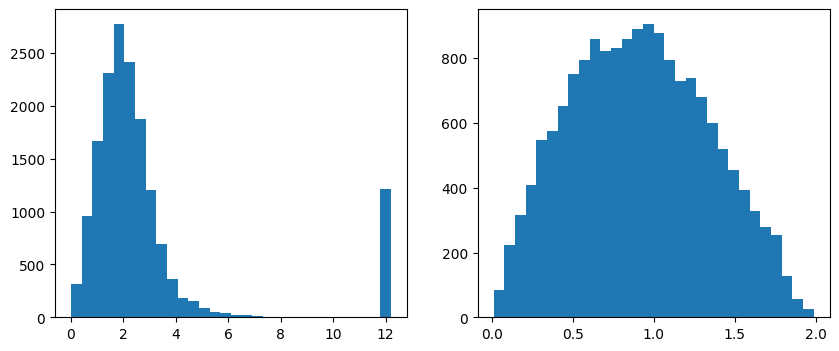

In [2]:
def sample_unit_ball(batch_shape, d):
    points = torch.randn(*batch_shape, d)
    
    norm = torch.norm(points, dim=-1, keepdim=True)
    unit_sphere_points = points / norm
    
    radius = torch.rand(*batch_shape, 1) ** (1.0 / d)
    unit_ball_points = unit_sphere_points * radius
    
    return unit_ball_points

batch_shape = (16, 32)
d = 2 

x = sample_unit_ball(batch_shape, d)
y = sample_unit_ball(batch_shape, d)
c = 1.
px = pmath.expmap0(x, c=c)
py = pmath.expmap0(y, c=c)

hyp_distances = pmath.dist_matrix(px, py)
euc_distances = torch.cdist(x, y)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(hyp_distances.numpy().flatten(), bins=30)
ax2.hist(euc_distances.numpy().flatten(), bins=30)
plt.show()

### Distance VS Curvature in dim = 2

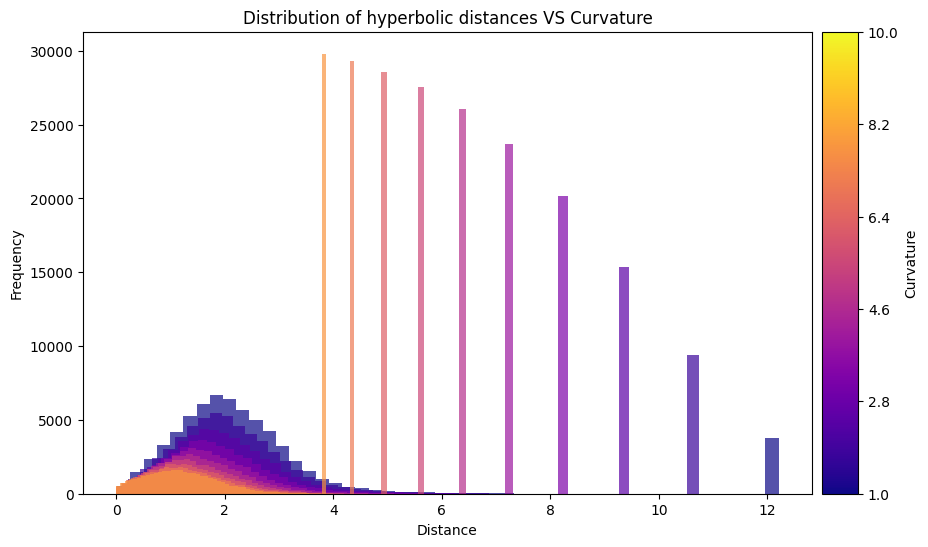

In [19]:
B, T, C = 16, 64, 2 

x_euc = sample_unit_ball((B, T), C)
y_euc = sample_unit_ball((B, T), C)

curvatures = np.logspace(0., 1., 10)

distances = {}
for c in curvatures:
    x = pmath.expmap0(x_euc, c=c)  
    y = pmath.expmap0(y_euc, c=c)  
    distances[c] = pmath.dist_matrix(x, y, c=c).view(-1).cpu().numpy()

n = len(curvatures)
colors = plt.cm.plasma(np.linspace(0.75, 0., n))[::-1]

fig, ax = plt.subplots(figsize=(10, 6))

for c, dists, color in zip(distances.keys(), distances.values(), colors):
    ax.hist(dists, bins=50, alpha=0.7, label=f'c={c:.2f}', color=color, density=False)

ax.set_title('Distribution of hyperbolic distances VS Curvature')
ax.set_xlabel('Distance')
ax.set_ylabel('Frequency')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(curvatures), vmax=max(curvatures)))
sm.set_array([])  

cbar = fig.colorbar(sm, cax=cax, ticks=np.linspace(min(curvatures), max(curvatures), num=6))
cbar.set_label('Curvature', x = 0.5)

# ax.legend()
# plt.savefig('1to30.jpg')
plt.show()

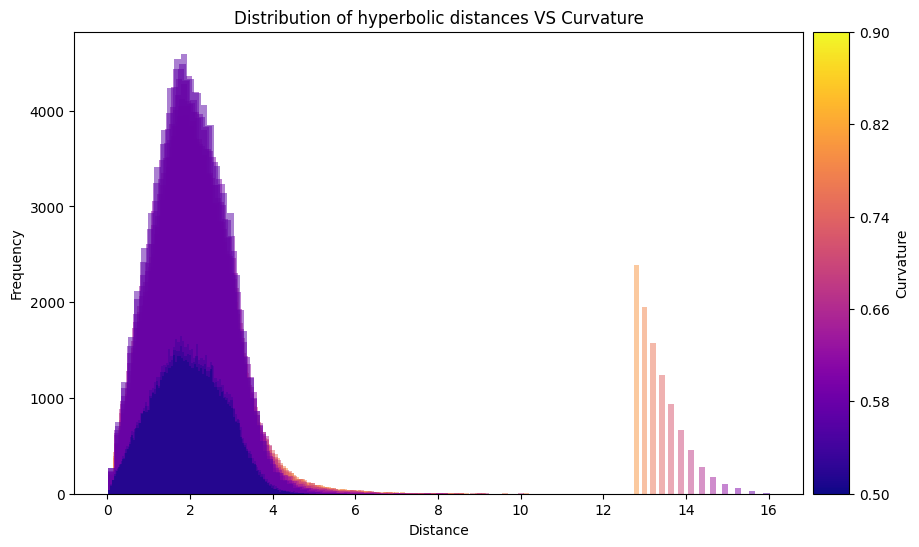

In [17]:
curvatures = np.linspace(0.9, 0.5, 16)

distances = {}
for c in curvatures:
    x = pmath.expmap0(x_euc, c=c)  
    y = pmath.expmap0(y_euc, c=c)  
    distances[c] = pmath.dist_matrix(x, y, c=c).view(-1).cpu().numpy()

n = len(curvatures)
colors = plt.cm.plasma(np.linspace(0.75, 0., n))

fig, ax = plt.subplots(figsize=(10, 6))

for c, dists, color in zip(distances.keys(), distances.values(), colors):
    ax.hist(dists, bins=100, alpha=0.5, label=f'c={c:.2f}', color=color, density=False)

ax.set_title('Distribution of hyperbolic distances VS Curvature')
ax.set_xlabel('Distance')
ax.set_ylabel('Frequency')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(curvatures), vmax=max(curvatures)))
sm.set_array([])  

cbar = fig.colorbar(sm, cax=cax, ticks=np.linspace(min(curvatures), max(curvatures), num=6))
cbar.set_label('Curvature', x = 0.5)

# ax.legend()
# plt.savefig('1to30.jpg')
plt.show()

### dim > 2

In [38]:
def sample_data(dimensions, curvatures, B=16, T=64):
    sampled_data = {}
    
    for d in dimensions:
        x_euc = sample_unit_ball((B, T), d)
        y_euc = sample_unit_ball((B, T), d)
        
        all_dists = []
        labels = []
        
        for c in curvatures:
            x = pmath.expmap0(x_euc, c=c)
            y = pmath.expmap0(y_euc, c=c)
            dists = pmath.dist_matrix(x, y, c=c).view(-1).cpu().numpy()
            all_dists.append(dists)
            labels.append(f'c = {c:.2f}')
        
        sampled_data[d] = (all_dists, labels)
    
    return sampled_data

dimensions = [4, 8, 16, 32]
curvatures = np.linspace(0.7, 1., 8)

sampled_data = sample_data(dimensions, curvatures)

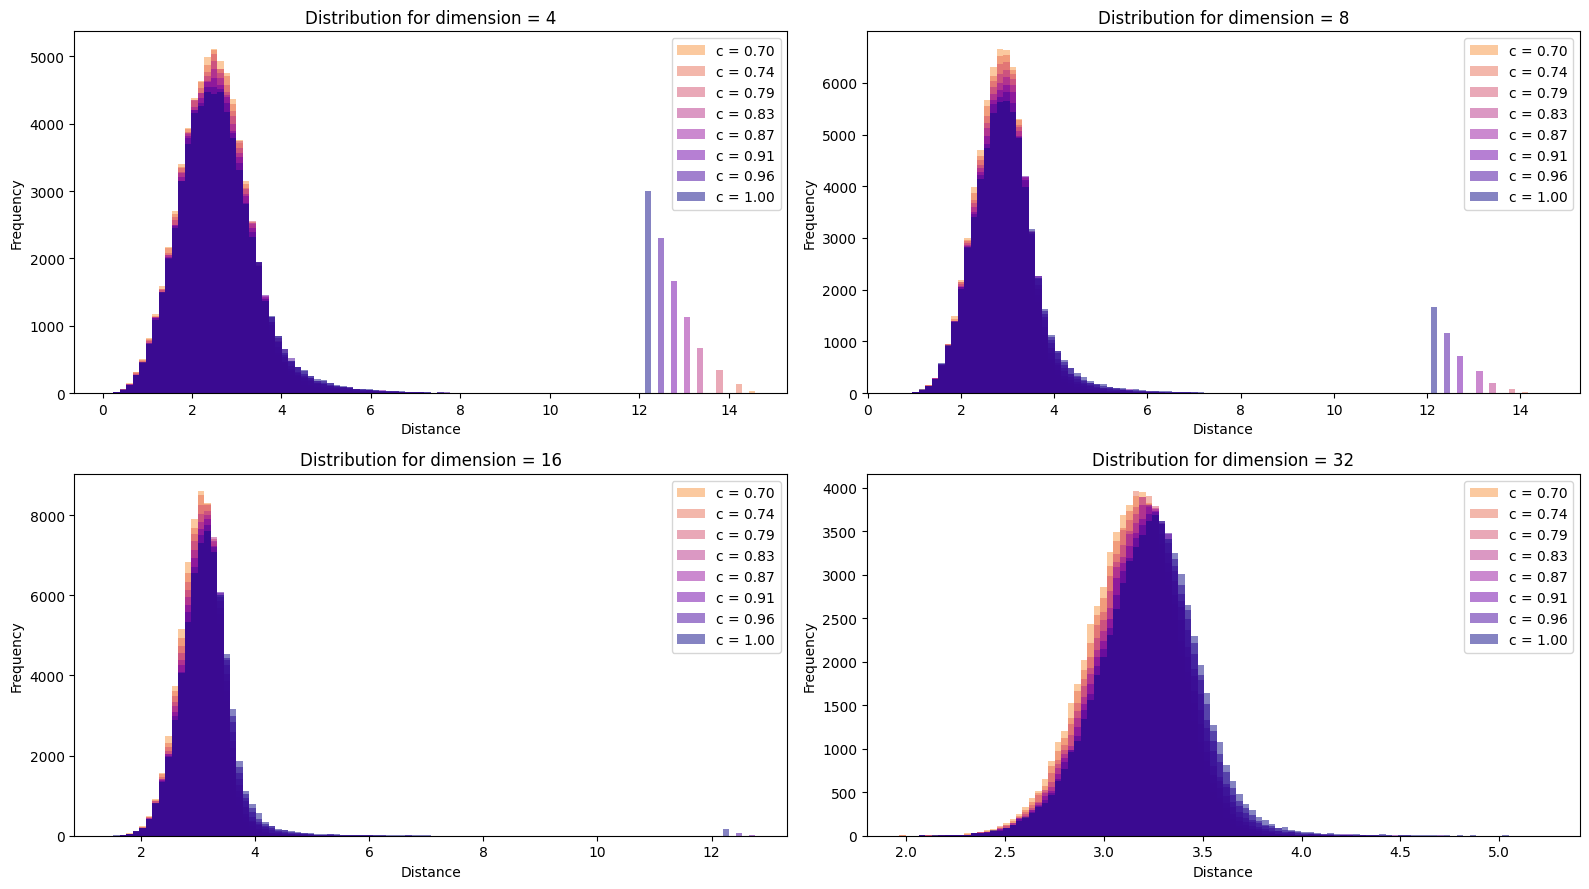

In [39]:
def plot_distributions(sampled_data, curvatures, figsize=(16, 16), bins=100, filename='out/dist_over_higher_dimensions.jpg'):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    for ax, (d, (all_dists, labels)) in zip(axes.flat, sampled_data.items()):
        n = len(curvatures)
        colors = plt.cm.plasma(np.linspace(0.75, 0., n))
        bins = np.histogram_bin_edges(np.concatenate(all_dists), bins=bins)
        
        for dists, label, color in zip(all_dists, labels, colors):
            ax.hist(dists, bins=bins, alpha=0.5, label=label, color=color, density=False)
        
        ax.set_title(f'Distribution for dimension = {d}')
        ax.set_xlabel('Distance')
        ax.set_ylabel('Frequency')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    
plot_distributions(sampled_data, curvatures, figsize=(16, 9))